In [24]:
# Plotting UMAP representations of scRNA/scATAC cross-omics data from Song et al., 2021

In [25]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import umap.plot
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [26]:
DataDir = "C:/Users/lexie/Documents/SMU/super-test/paper-code/scGCN_tensorflow2/input"

In [27]:
DataPath1 = '{}/Data1.csv'.format(DataDir)
DataPath2 = '{}/Data2.csv'.format(DataDir)
LabelsPath1 = '{}/Label1.csv'.format(DataDir)
LabelsPath2 = '{}/Label2.csv'.format(DataDir)

In [28]:
# read the data
data1 = pd.read_csv(DataPath1, index_col=0, sep=',')
data2 = pd.read_csv(DataPath2, index_col=0, sep=',')
lab_label1 = pd.read_csv(LabelsPath1, header=0, index_col=False, sep=',')
lab_label2 = pd.read_csv(LabelsPath2, header=0, index_col=False, sep=',')

lab_data1 = data1.reset_index(drop=True)  #.transpose()
lab_data2 = data2.reset_index(drop=True)  #.transpose()
lab_label1.columns = ['treatment_time']
lab_label2.columns = ['treatment_time']


In [29]:
# organize the data and labels into pandas dataframes


# value for "omics" is 0 for scRNA-seq and 1 for scATAC-seq
# lab_data1['omics'] = [0] * 3260
# lab_data2['omics'] = [1] * 3260

# data1_combined = pd.concat([lab_label1, lab_data1], axis=1)
# data2_combined = pd.concat([lab_label2, lab_data2], axis=1)

combined = pd.concat([lab_data1, lab_data2])
labels = pd.concat([lab_label1,lab_label2])
altogether = pd.concat([labels,combined],axis = 1)
                       
altogether

,treatment_time,AC013448.2,AADACL2,HSD17B6,RP11-383H17.4,CRY2,RP1-159G19.1,CACNA1D,CTD-2247C11.2,RP11-739G5.1,...,TMEM108,CCDC61,SCARA3,LPIN3,HOXB3,HMSD,LHX2,NRP2,KRTAP6-2,CTB-27N1.1
0,3,0,0,1,0,0,0,0,0,4,...,0,0,1,0,0,2,0,2,0,0
1,0,7,0,4,7,2,0,0,13,0,...,2,0,0,0,0,3,1,1,0,0
2,3,0,1,2,0,2,0,2,0,0,...,8,0,0,0,0,7,0,1,0,0
3,1,1,1,1,8,0,4,0,0,2,...,6,0,0,0,0,0,0,1,0,0
4,1,2,0,3,1,2,0,1,1,0,...,0,0,1,0,0,5,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3256,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3257,3,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3258,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# replace the treatment times with consecutive digits
types = np.unique(lab_label1['treatment_time']).tolist()
print(types)

key = np.array(range(len(types)))
print(key)

[0, 1, 3]
[0 1 2]


In [31]:
cell_data = combined.values
cell_data.shape

(6520, 2000)

# Cross-omics raw data clustering via UMAP

In [47]:
# use UMAP for dimension reduction

reducer = umap.UMAP()
cell_embedding = reducer.fit_transform(cell_data)
cell_embedding.shape

(6520, 2)

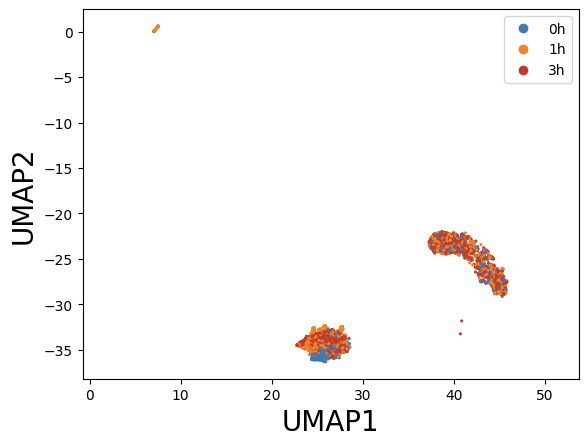

In [48]:
# UMAP plot by treatment time in raw data

classes = ['0h', '1h', '3h']
colors = ListedColormap(['#4577B1', '#ED8427', '#C23A2B'])

scatter = plt.scatter(
        cell_embedding[:, 0],
        cell_embedding[:, 1],
        s = 1.5,
        c= altogether.treatment_time,
        cmap = colors )
plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of cross-omics raw dataset', fontsize=15)
plt.xlabel('UMAP1', fontsize = 20)
plt.ylabel('UMAP2', fontsize = 20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)


# Cross-omics scGCN results

In [34]:
# import cross-omics scGCN result

DataDir = "C:/Users/lexie/Documents/SMU/super-test/paper-code/scGCN_tensorflow2/checkpoints"
best_valid_meta = '{}/best_validation.meta'.format(DataDir)
best_valid = '{}/best_validation'.format(DataDir)

import tensorflow as tf

# access the meta graph
with tf.compat.v1.Session() as sess:    
    saver = tf.compat.v1.train.import_meta_graph(best_valid_meta)
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
graph = tf.compat.v1.get_default_graph()
all_vars = tf.compat.v1.get_collection('vars')

INFO:tensorflow:Restoring parameters from checkpoints\best_validation


In [35]:
# get a list of the variables at the checkpoint
check_list = tf.train.list_variables(best_valid)
print(check_list)

# read the value of one of the checkpoint variables
values = list()
for i in range(len(check_list)):
    values.append(tf.compat.v1.train.load_variable('checkpoints', check_list[i][0]))

# raw data
data1 = pd.read_csv(DataPath1, index_col=0, sep=',')
data2 = pd.read_csv(DataPath2, index_col=0, sep=',')
lab_data1 = data1.reset_index(drop=True)  #.transpose()
lab_data2 = data2.reset_index(drop=True)  #.transpose()

[('beta1_power', []), ('beta2_power', []), ('scgcn/graphconvolution_1_vars/weights_0', [2000, 32]), ('scgcn/graphconvolution_1_vars/weights_0/Adam', [2000, 32]), ('scgcn/graphconvolution_1_vars/weights_0/Adam_1', [2000, 32]), ('scgcn/graphconvolution_2_vars/weights_0', [32, 3]), ('scgcn/graphconvolution_2_vars/weights_0/Adam', [32, 3]), ('scgcn/graphconvolution_2_vars/weights_0/Adam_1', [32, 3])]


In [36]:
print(check_list[2])
print(check_list[5])

('scgcn/graphconvolution_1_vars/weights_0', [2000, 32])
('scgcn/graphconvolution_2_vars/weights_0', [32, 3])


In [37]:
# load in the adjacency matrix Atilda
AdjPath = "C:/Users/lexie/Documents/SMU/super-test/paper-code/scGCN_tensorflow2/adjacency_new.csv"
adj = pd.read_csv(AdjPath, index_col=0, sep=',')
adj = adj.reset_index(drop=True)  #.transpose()
adj

,0,1,2,3,4,5,6,7,8,9,...,6510,6511,6512,6513,6514,6515,6516,6517,6518,6519
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.000000,0.0,0.0
6516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0
6517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.0
6518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0


In [38]:
# xt is the input matrix with dimensions 
xt = pd.concat([lab_data1, lab_data2]) 
out0 = np.matmul(adj,xt)
print(out0.shape)

# weights matrix w0 has dimensions 2000 by 32
weights0 = values[2]
out1 = np.matmul(out0,weights0)
print(out1.shape)

def relu(x):
    return(np.maximum(0, x))

out2 = np.matmul(adj,relu(out1))
print(out2.shape)

# weights matrix w1 has dimensions 32 by 3
weights1 = values[5]
out3 = np.matmul(out2, weights1)
print(out3.shape)


C:\Users\lexie\AppData\Local\Temp\ipykernel_28940\2529873412.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  out0 = np.matmul(adj,xt)


(6520, 2000)
(6520, 32)
(6520, 32)
(6520, 3)


C:\Users\lexie\AppData\Local\Temp\ipykernel_28940\2529873412.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  out2 = np.matmul(adj,relu(out1))


# UMAP by treatment time 

In [39]:
# use UMAP for dimension reduction

reducer = umap.UMAP()
omics_embedding = reducer.fit_transform(out3)
omics_embedding.shape

(6520, 2)

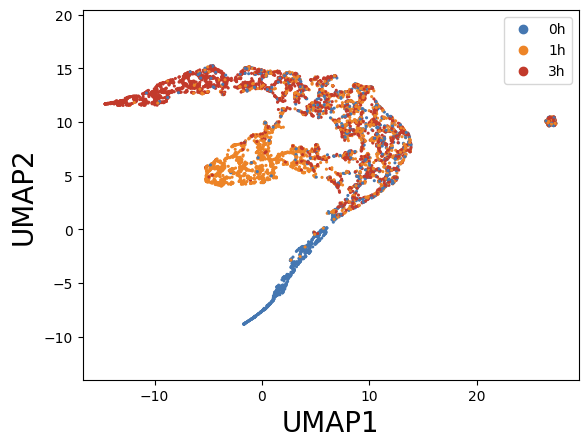

In [40]:
# add the labels 
#altogether = pd.concat([labels,out3],axis = 1)
classes = ['0h', '1h', '3h']
colors = ListedColormap(['#4577B1', '#ED8427', '#C23A2B'])

# plotting UMAP representation
scatter = plt.scatter(
        omics_embedding[:, 0],
        omics_embedding[:, 1],
        s = 1.5,
        c= altogether['treatment_time'],
        cmap = colors)
plt.gca().set_aspect('equal', 'datalim')
# plt.title('By treatment time: UMAP projection of cross-omics scGCN output', fontsize=14)
plt.xlabel('UMAP1', fontsize = 20)
plt.ylabel('UMAP2', fontsize = 20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

# UMAP scRNA-seq for scATAC-seq

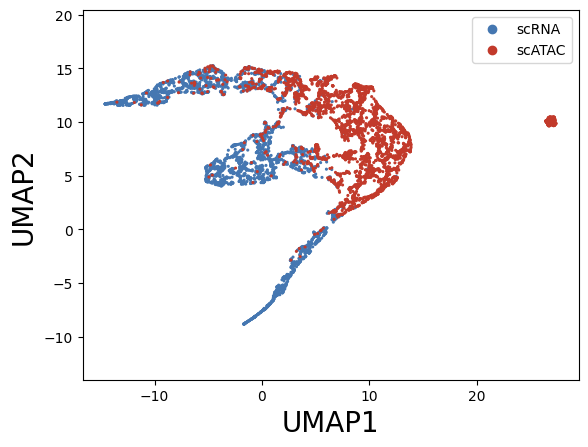

In [41]:
# UMAP plot by dataset in raw data

classes = ['scRNA','scATAC']
colors = ListedColormap(['#4577B1','#C23A2B'])

scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s = 1.5,
        c= [[0]*3260, [1]*3260],
        cmap = colors )
plt.gca().set_aspect('equal', 'datalim')
#plt.title('scRNA vs scATAC:  UMAP projection of cross-omics scGCN result', fontsize=14)
plt.xlabel('UMAP1', fontsize = 20)
plt.ylabel('UMAP2', fontsize = 20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)


In [42]:
# load in dense feature matrix
featDir = "C:/Users/lexie/Documents/SMU/super-test/paper-code/scGCN_tensorflow2/dense_matrix_features.csv"
feat = pd.read_csv(featDir, index_col=0, sep=',')
feat = feat.reset_index(drop=True)  #.transpose()
feat

,1,2,3,4,5,6,7,8,9,10,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.005096,0.000000,0.000000,0.000000,0.000000,0.007643,0.000000,0.002548,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001274,0.000000,0.0
1,0.000000,0.020725,0.010363,0.000000,0.000000,0.000000,0.000000,0.002591,0.010363,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.013167,0.002079,0.001386,0.000000,0.000000,0.002772,0.000000,0.000693,0.000000,...,0.002772,0.000000,0.000000,0.000000,0.0,0.004158,0.000000,0.001386,0.000000,0.0
3,0.000000,0.011374,0.001896,0.000000,0.000000,0.000000,0.000000,0.000000,0.005687,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.008531,0.000000,0.000000,0.000000,0.0
4,0.003419,0.013675,0.013675,0.000000,0.000000,0.000000,0.001709,0.000000,0.005128,0.000000,...,0.000000,0.003419,0.000000,0.000000,0.0,0.000000,0.001709,0.003419,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,0.000000,0.006289,0.002096,0.002096,0.000000,0.002096,0.002096,0.002096,0.008386,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
6516,0.000000,0.000000,0.006656,0.000000,0.003328,0.003328,0.000000,0.000000,0.000000,0.000000,...,0.001664,0.000000,0.000000,0.001664,0.0,0.011647,0.000000,0.001664,0.000000,0.0
6517,0.004222,0.004926,0.000000,0.002815,0.000000,0.002815,0.000000,0.007037,0.000000,0.000000,...,0.000704,0.000000,0.000704,0.000000,0.0,0.000704,0.000000,0.002111,0.001407,0.0
6518,0.000856,0.003853,0.001284,0.000000,0.000000,0.000428,0.000856,0.000428,0.000428,0.001284,...,0.001284,0.000000,0.001284,0.000000,0.0,0.002140,0.000000,0.000856,0.000000,0.0


## UMAP using dense output matrix

In [43]:
# use UMAP for dimension reduction
reducer = umap.UMAP()
embed = reducer.fit_transform(feat)
embed.shape

(6520, 2)

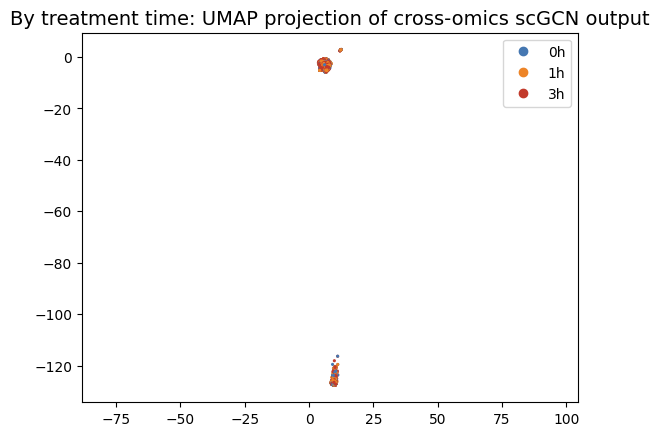

In [44]:
# add the labels 
#altogether = pd.concat([labels,out3],axis = 1)
classes = ['0h', '1h', '3h']
colors = ListedColormap(['#4577B1', '#ED8427', '#C23A2B'])

# plotting UMAP representation
scatter = plt.scatter(
        embed[:, 0],
        embed[:, 1],
        s = 1.5,
        c= altogether['treatment_time'],
        cmap = colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('By treatment time: UMAP projection of cross-omics scGCN output', fontsize=14)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)